In [1]:
from site_visit import *
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from scipy.spatial import distance_matrix
from scipy.stats import ttest_ind
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.decomposition import KernelPCA

#color_lst = px.colors.qualitative.Light24

prop_cycle = plt.rcParams['axes.prop_cycle']
color_lst = prop_cycle.by_key()['color']

color_lst = px.colors.qualitative.Light24

## Function Defs

In [4]:
#def eval_on_random(config, vocab_lsts, count_lsts):
def eval_on_random(config, spatial_data, vocab_lsts, count_lsts):
    
    #_data = [row for row in csv.DictReader(open(config['DATA']), delimiter='\t')]
    sample = []
    p = config['DEV']
    for t in range(1,7):
        for step in spatial_data[(p,str(t))]:
            if step % 450 == 0:
                sample.append({'participant': p, 'task': str(t), 'step': step, 'lemma': 'NA', 'pos': 'NA'})
                
    #sample = random.sample(_data, 10)
    #sample = [e for e in _data if e['participant'] == config['DEV']]
    #sample = sorted(sample, key=lambda e:(e['task'], int(e['step'])))
    
    sys.stderr.write("Data: %d items\n"%len(sample))

    #dat, _ = _make_raw_spatial_mats(sample, spatial_data,
    #                                           feat_lst=config['FEATURES'],
    #                                           basic_feats=config['BASIC_FEATS'],
    #                                           use_objs=config['OBJS'],
    #                                           use_most_moving=config['MOST_MOVING'],
    #                                           window_size = config['WINDOW'],
    #                                           logdir=None)
    
    dat, _ = _make_pretrained_cnn_mats(sample, window_size = config['WINDOW'], logdir=None)

    return dat

In [103]:
def prep_data(config, spatial, logdir, use_cnn = False):
    _data = [row for row in csv.DictReader(open(config['DATA']), delimiter='\t')]
    sys.stderr.write("Data: %d items\n"%len(_data))

    vocab_lsts, count_lsts = get_vocabs(_data, MODE=config['MODE'],
                                        K=config['K'], CUTOFF=config['CUTOFF'])
    
    top_words = ["pick_VERB", "put_VERB", "hold_VERB"] 
    #top_words = get_top_words(config['POS'])
    #top_words = [w for i, w in enumerate(vocab_lsts[1])
    #             if (w.split('_')[1] == config['POS'] and count_lsts[1][i] >= 10)]
    #sorted_words = [w for w, c in sorted(zip(vocab_lsts[1], count_lsts[1]), key=lambda e:e[1], reverse=True)]
    #sorted_pos = [w for w in sorted_words if (config['POS'] in w) and (w not in top_words)]
    #top_words += sorted_pos[:15]
    
    _data = [d for d in _data if '%s_%s'%(d['lemma'], d['pos']) in top_words]
    sys.stderr.write("Filtered Data: %d items\n"%len(_data))
    

    if use_cnn:
        featurized_data = _make_pretrained_cnn_mats(_data, window_size = config['WINDOW'],
                                                logdir=logdir)
        fnames = []
    else:
        featurized_data, dv = _make_raw_spatial_mats(_data, spatial,
                                               feat_lst=config['FEATURES'],
                                               basic_feats=config['BASIC_FEATS'],
                                               use_objs=config['OBJS'],
                                               use_most_moving=config['MOST_MOVING'],
                                               window_size = config['WINDOW'],
                                               logdir=logdir)
        fnames = dv.get_feature_names()

    if config['MODE'] == 'random':
        rows, cols = featurized_data.X.shape
        featurized_data.X = np.random.rand(rows, cols)
    if config['MODE'] == 'oracle':
        rows, cols = featurized_data.X.shape
        words = sorted(list(set(featurized_data.y)))
        featurized_data.X = np.random.rand(rows, len(words))
        for i, w in enumerate(featurized_data.y):
            featurized_data.X[i, words.index(w)] = 1
    
    return vocab_lsts, count_lsts, top_words, featurized_data, fnames

def filter_and_dedup(data_mat, top_words):
    data_mat_filtered = filter_mats(data_mat, top_words)

    dedup = []
    seen = set()
    for i, (mm, yy) in enumerate(zip(data_mat_filtered.meta, data_mat_filtered.y)):
        part, task, step, steps = mm.split()
        if (part, task, yy) not in seen:
            seen.add((part, task, yy))
            dedup.append(i)

    data_mat_filtered.X = data_mat_filtered.X[dedup]
    data_mat_filtered.y = data_mat_filtered.y[dedup]
    data_mat_filtered.meta = data_mat_filtered.meta[dedup]
    
    return data_mat_filtered


In [7]:
def name_from_config(config):
    fnames = ['k', 'win'] 
    fs = ['K', 'WINDOW'] 

    return '_'.join(['%s=%s'%(fnames[i],
                              config[fs[i]]) for i in range(len(fs))])

def make_directories(config):

    make = config['LOG']
    
    # set up directories and such
    inp = config['MODE'].split('.')[0].split('/')[-1]

    inp += '_' + name_from_config(config)

    rootdir = 'spatial_eval/%s/'%inp
    
    figdir = rootdir + 'red=%s_dim=%s_sup=%s/figures'%(config['RED'],
                                                    config['DIM'], config['SUP'])
    repdir = rootdir + 'red=%s_dim=%s_sup=%s/reports'%(config['RED'],
                                                config['DIM'], config['SUP'])
    if make:
        if not os.path.exists(figdir):
            os.makedirs(figdir)
        if not os.path.exists(repdir):
            os.makedirs(repdir)
        
    return repdir, figdir

def vocab_mat_figures(outpath, nm, mat, words, mn, mx, fmt='png', save=False):
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    plt.figure(figsize=(4, 0.2*len(words)))
    sns.heatmap(mat, cmap="coolwarm_r", vmin=mn, vmax=mx)
    plt.yticks(np.arange(len(words))+0.5, words, rotation="horizontal")
    if save:
        plt.savefig('%s/agg_%s.%s'%(outpath, nm, fmt), bbox_inches='tight')
    plt.show()
    plt.clf()
    
def vocab_mat_figures_indv(outpath, data_mat, mn, mx, fmt='png', save=False):
    use_X = data_mat.X
    use_y = data_mat.y
    use_m = data_mat.meta
    for w in set(use_y):
        idx = [i for i, u in enumerate(use_y) if u == w]
        if len(idx) == 0:
            continue
        plt.figure(figsize=(4, 0.2*len(idx)))
        sns.heatmap(use_X[idx, :], cmap="coolwarm_r", vmin=mn, vmax=mx)
        plt.title(w)
        ticks = use_m[idx]
        plt.yticks(np.arange(len(ticks))+0.5, ticks, rotation="horizontal")
        if save:
            plt.savefig('%s/%s_full.%s'%(outpath, w, fmt), bbox_inches='tight')
        plt.show()
        plt.clf()
        
def avg_mat(data_mat, words):
    use_X = data_mat.X
    use_y = data_mat.y
    use_m = data_mat.meta
    
    n_obs, n_feat = use_X.shape
    mat = np.zeros((len(words), n_feat))
    for i, w in enumerate(words):
        avg = use_X[use_y == w, :].mean(axis=0)
        mat[i, :] = avg
    return mat

In [8]:
def _max_dist_change_feats(ref, mat):
    dists = distance_matrix(ref.reshape(1, -1), mat)

    max_idx = [e for e in reversed(dists[0].argsort())][0]
    mx = dists[0, max_idx]

    mxx, mxy, mxz = mat[max_idx, :]
    names = ["dist", "x", "y", "z"]
    feats = [mx, mxx, mxy, mxz]
    return feats, names

def _dist_change_feats(s, e):
    
    d = euclidean(s, e)

    names = ["dist", "x", "y", "z"]
    feats = [d] + [s[i] - e[i] for i in range(3)]
    return feats, names

def _trajectory_feats(span, dims): 
    
    feats = []
    names = []
    
    # start value of each dim
    names += ["start_%s"%d for d in dims]
    feats += list(span[0, :])
    
    # peak value of each dim
    peak = span.max(axis=0)
    names += ["peak_%s"%d for d in dims]
    feats += list(peak)
    
    # trough value of each dim
    trough = span.min(axis=0)
    names += ["trough_%s"%d for d in dims]
    feats += list(trough)

    # end value of each dim
    names += ["end_%s"%d for d in dims]
    feats += list(span[-1, :])
    
    # break trajectory into 3 pieces, start->key point 1, kp1 -> kp2, kp2->end
    peak_idx = np.argmax(span, axis=0)
    trough_idx = np.argmin(span, axis=0)
    for i, d in enumerate(dims):
        start = span[0, i]
        end = span[-1, i]
        if peak_idx[i] < trough_idx[i]:
            kp1 = peak[i]
            kp2 = trough[i]
        else:
            kp2 = peak[i]
            kp1 = trough[i]
        names += ['st-kp1_%s'%d, 'kp1-kp2_%s'%d, 'kp2-end_%s'%d]
        feats += [kp1-start, kp2-kp1, end-kp2]
        
        names += ['st-end_%s'%d]
        feats += [end-start]
        
    return feats, names
        
def _avg_feats(span, dims):
    
    avg = span.mean(axis=0)
    mn = span.min(axis=0)
    mx = span.max(axis=0)

    names = ["%s_avg"%d for d in dims]
    names += ["%s_min"%d for d in dims]
    names += ["%s_max"%d for d in dims]
    names += ["%s_start"%d for d in dims]
    names += ["%s_end"%d for d in dims]

    feats = [avg[i] for i in range(len(dims))]
    feats = [mn[i] for i in range(len(dims))]
    feats = [mx[i] for i in range(len(dims))]

    feats += list(span[0, :])
    feats += list(span[-1, :])
    return feats, names

def _var_feats(span, dims):
    
    avg = span.var(axis=0)

    names = ["%s_var"%d for d in dims]
    feats = [avg[i] for i in range(len(dims))]
    return feats, names

def _dist_to_obj_feats(obj, ref):

    at_start = euclidean(obj[0], ref[0])
    at_end = euclidean(obj[-1], ref[-1])
    
    N, _ = obj.shape

    diff = obj - ref
    sq = (diff * diff).sum(axis=1) # squared differences
    dists = np.sqrt(sq)

    avg = dists.mean()
    var = dists.var()
    mn = dists.min()
    mx = dists.max()
    argmn = np.argmin(dists, axis=0)
    argmx = np.argmax(dists, axis=0)
    #print("mn=%.02f argmn=%.02f mx=%.02f argmx=%.02f"%(mn, argmn, mx, argmx))
    
    names = ["start", "end", "mean", 'var', "min", "max", "min_idx", "max_idx"]
    feats = [at_start, at_end, avg, var, mn, mx, argmn/N, argmx/N]
    return feats, names

def get_features(span, all_feats, all_obj_spans, use=None):

    feats = []
    names = []
    
    # distance to the floor
    if (use is None) or ('dist_to_surfaces' in use): 
        px = all_feats.index('posX')
        py = all_feats.index('posY')
        pz = all_feats.index('posZ')
        this = span[:, [px, py, pz]]
        
        ref = all_obj_spans['Floor'][:, [px, py, pz]]
        fs, ns = _dist_to_obj_feats(this, ref)
        names += ["dist_to_floor_"+e for e in ns]
        feats += fs
        
        ref = all_obj_spans['Counter'][:, [px, py, pz]]
        fs, ns = _dist_to_obj_feats(this, ref)
        names += ["dist_to_counter_"+e for e in ns]
        feats += fs
    
    # distance to the right hand
    if (use is None) or ('dist_to_rhand' in use): 
        px = all_feats.index('posX')
        py = all_feats.index('posY')
        pz = all_feats.index('posZ')
        this = span[:, [px, py, pz]]
        ref = all_obj_spans['RightHand'][:, [px, py, pz]]
        fs, ns = _dist_to_obj_feats(this, ref)
        names += ["dist_to_rhand_"+e for e in ns]
        feats += fs
        
    # distance to the left hand
    if (use is None) or ('dist_to_lhand' in use):  
        px = all_feats.index('posX')
        py = all_feats.index('posY')
        pz = all_feats.index('posZ')
        this = span[:, [px, py, pz]]
        ref = all_obj_spans['LeftHand'][:, [px, py, pz]]
        fs, ns = _dist_to_obj_feats(this, ref)
        names += ["dist_to_lhand_"+e for e in ns]
        feats += fs
        
    # distance to head
    if (use is None) or ('dist_to_head' in use):  
        px = all_feats.index('posX')
        py = all_feats.index('posY')
        pz = all_feats.index('posZ')
        this = span[:, [px, py, pz]]
        ref = all_obj_spans['Head'][:, [px, py, pz]]
        fs, ns = _dist_to_obj_feats(this, ref)
        names += ["dist_to_head_"+e for e in ns]
        feats += fs
    
    # average velocity
    if (use is None) or ('vel_avg' in use):       
        px = all_feats.index('velX')
        py = all_feats.index('velY')
        pz = all_feats.index('velZ')
        fs, ns = _avg_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
        if np.isnan(fs).any():
            print("NaNs!! avg vel %s"%(' '.join(ns)), fs)
        names += ["vel_avg_"+e for e in ns]
        feats += fs
        
    # variation in velocity
    if (use is None) or ('vel_var' in use):       
        px = all_feats.index('velX')
        py = all_feats.index('velY')
        pz = all_feats.index('velZ')
        fs, ns = _var_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
        if np.isnan(fs).any():
            print("NaNs!! avg vel %s"%(' '.join(ns)), fs)
        names += ["vel_var_"+e for e in ns]
        feats += fs
    
    # trajectory data start, peak, trough, end 
    if (use is None) or ('trajectory' in use):
        px = all_feats.index('posX')
        py = all_feats.index('posY')
        pz = all_feats.index('posZ')
        fs, ns = _trajectory_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
        if np.isnan(fs).any():
            print("NaNs!! %s"%(' '.join(ns)), fs)
        names += ["traj_"+e for e in ns]
        feats += fs
        
    # average relative position   
    if (use is None) or ('relPos_avg' in use):       
        px = all_feats.index('relPosX')
        py = all_feats.index('relPosY')
        pz = all_feats.index('relPosZ')
        fs, ns = _avg_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
        if np.isnan(fs).any():
            print("NaNs!! avg vel %s"%(' '.join(ns)), fs)
        names += ["relPos_avg_"+e for e in ns]
        feats += fs
            
    return feats, names

In [9]:
def get_most_moving(obj_spans, fnames):
    max_objs = []
    x = fnames.index('velX')
    y = fnames.index('velY')
    z = fnames.index('velZ')
    for obj, span in obj_spans.items():
        try:
            vals, _ = _max_dist_change_feats(span[0, [x, y, z]], span[:, [x, y, z]])
        except IndexError:
            print(span)
        d = vals[0] # euclidean distance
        max_objs.append((obj, d))
    rank = sorted(max_objs, key=lambda e:e[1], reverse=True)
    return [o for o, _ in rank if 'Hand' not in o][0]
        
def _make_raw_spatial_mats(D, spatial_data, feat_lst=[], basic_feats=[],
                           use_objs=[], use_most_moving=True, window_size=100,
                          logdir=None):
    
    all_objs = [l.strip() for l in open('obj_names.txt').readlines()]
    all_feats = ["relPosX", "relPosY", "relPosZ", "posX", "posY", "posZ",
                'velX', 'velY', 'velZ', 'relVelX', 'relVelY', 'relVelZ']
    
    N = len(D)
    feats = []
    lbls = []
    meta = []
    if logdir is not None:
        logfile = open('%s/feature_dump.tsv'%logdir, 'w')
    for i, d in enumerate(D):
        sidx = int(d['step'])
        start = sidx #-window_size
        end = sidx+window_size
        L = 1+end-start
        w = d['lemma']+'_'+d['pos']
        p = d['participant']
        t = d["task"]
        lbls.append(w)
        meta.append(p + ' ' + t + ' %s '%sidx + '%s-%s'%(start, end))
        fv = {}
        obj_spans = {o: [] for o in all_objs}
        for si, step in enumerate(range(start, end+1)):
            if step in spatial_data[(p, t)]:
                sdata = spatial_data[(p, t)][step]
                for obj in all_objs:
                    if obj in sdata:
                        frame = sdata[obj]
                        row = [frame[e] for e in all_feats]
                        if not(np.isnan(row).any()):
                            obj_spans[obj].append(row)
        obj_spans = {o: np.array(v) for o, v in obj_spans.items() if len(v)>0}
        
        covered = set()
        for obj in use_objs:
            x, names = get_features(obj_spans[obj], all_feats, obj_spans, use=feat_lst)
            fv.update({obj+'_'+n: xx for (xx, n) in zip(x, names)})
            covered.add(obj)
            
        if use_most_moving:
            most_moving_obj = get_most_moving(obj_spans, all_feats)
            x, names = get_features(obj_spans[most_moving_obj], all_feats, obj_spans, use=feat_lst)
            fv.update({'most_moving_'+n: xx for (xx, n) in zip(x, names)})
            covered.add(most_moving_obj)
            
        for obj in all_objs:
            #if obj not in obj_spans:
            #    print("no object data for %s"%obj)
            if (obj not in covered) and (obj in obj_spans):
                x, names = get_features(obj_spans[obj], all_feats,
                                        obj_spans, use=basic_feats)
                fv.update({obj+'_'+n: xx for (xx, n) in zip(x, names)})
            
        #if np.isnan(fv.values()).any():
        #    print("NaNs!!1", i, fv)
        feats.append(fv)
        if logdir is not None:
            logfile.write('%s\t%s\t%s\t%s-%s\t%s\tfdim=%d\t%s\n'%(w, p, t, start, end, most_moving_obj,
                                                              len(fv.keys()), json.dumps(fv)))
    if logdir is not None:
        logfile.close()
    dv = DictVectorizer(sparse=False)
    Xmat = dv.fit_transform(feats)
    print("feats", Xmat.shape)
    #transformer = KernelPCA(n_components=100, kernel='sigmoid')
    #Xmat = transformer.fit_transform(Xmat)
    #print("kernel feats", Xmat.shape)
    return DataMat(Xmat, lbls, meta), dv

In [74]:
def _make_pretrained_cnn_mats(D, window_size, logdir=None):
    
    sys.stderr.write("Loading pretrained embeddings\n")
    EMB_DIM = 2048
    embs = {}
    with open('cnn_embeddings.txt') as f:
        for line in f:
            p, t, s, emb = line.strip().split('\t')
            embs[(p, t, int(s))] = np.array([float(e) for e in emb.split()])
    sys.stderr.write("Finished loading\n")        
    
    N = len(D)
    feats = []
    lbls = []
    meta = []
    #if logdir is not None:
    #    logfile = open('%s/cnn_feature_dump.tsv'%logdir, 'w')
    for i, d in enumerate(D):
        sidx = int(d['step'])
        start = sidx 
        end = sidx+window_size
        L = 1+end-start
        w = d['lemma']+'_'+d['pos']
        p = d['participant']
        t = d["task"]
        fv = []
        for si, step in enumerate(range(start, end+1)):
            if (p, t, step) in embs:
                e = embs[(p, t, step)]
                fv.append(e)
        fv = np.array(fv)
        try:
            avg = fv.mean(axis=0)
            mn = fv.min(axis=0)
            mx = fv.min(axis=0)
            st = fv[0, :]
            ed = fv[-1, :]
            feats.append(np.hstack((avg, mn, mx, st, ed)))
            lbls.append(w)
            meta.append(p + ' ' + t + ' %s '%sidx + '%s-%s'%(start, end))
        except ValueError:
            print("fv", p, t, sidx, fv.shape)
            #print([step for step in range(start, end+1)])
        #if logdir is not None:
        #    logfile.write('%s\t%s\t%s\t%s-%s\t%s\tfdim=%d\t%s\n'%(w, p, t, start, end,
        #                                                   json.dumps(fv))
    #if logdir is not None:
    #    logfile.close()
    
    Xmat = np.array(feats)
    print("feats", Xmat.shape)
    return DataMat(Xmat, lbls, meta)

In [12]:
def get_sims_avged(m1, m2, words, outfile, save=False):
    sims = cosine_similarity(m1, m2)
    ranks = []
    rand = []
    lines = []
    N = len(words)
    for i, w in enumerate(words):
        v1 = m1[i, :]
        v2 = m2[i, :]
        ssim = sims[i, i]
        
        max_idxs = [e for e in reversed(sims[i, :].argsort())] # to get descending order
        max_idx = max_idxs[0]
        
        # benefit-of-the-doubt MRR computation
        eq_set = np.where(sims[i, :] == ssim)[0] # all the words that have the same (max) similarity to query
        min_rank = N+1
        for idx in eq_set:
            min_rank = min(min_rank, np.where(max_idxs == idx)[0])
        ranks.append(1/(min_rank+1))
        rand.append(1/(random.choice(max_idxs)+1))
        lines.append((ssim, '%s\tselfsim=%.02f\trank=%d\tmaxsim=%s (%.02f)'%(w,
              ssim, min_rank, words[max_idx], sims[i, max_idx])))
    sum_line = "MRR = %.02f (Ceil=%.02f, Rand=%.02f, Floor=%.02f)"%(sum(ranks)/len(ranks),
                                                                    1, sum(rand)/len(rand), 1/N)
    if save:
        out = open(outfile, mode='w')
        out.write("%s\n"%(sum_line))
        for _, l in sorted(lines, key=lambda e:e[0], reverse=True):
            out.write(l+'\n')
        out.close()
    return sum_line

def get_sims(tr, dv, tr_lbl, dv_lbl, tr_meta, dv_meta, outdir, save=False):
    sims = cosine_similarity(dv, tr)
    rand = []
    debug_lines = []
    N = len(dv_lbl)
    by_lbl = {}
    by_w = {w: [] for w in set(dv_lbl)}
    pat3 = {w: [] for w in set(dv_lbl)}
    
    cm = np.zeros((len(tr_lbl), len(tr_lbl)))
    rand = []
    rand_p3 = []
    
    for i, w in enumerate(dv_lbl):

        max_idxs = [e for e in reversed(sims[i, :].argsort())] # to get descending order
        max_idx = max_idxs[0]
        
        # find the rank of the most-similar instance of the true word
        matches = [idx for idx, u in enumerate(tr_lbl) if u == w]
        ranked_correct = [(idx, max_idxs.index(idx)) for idx in matches]
        top_correct_idx, top_correct_rank = sorted(ranked_correct, key=lambda e:e[1])[0]
        
        by_w[w].append(1./(1+top_correct_rank))
        pat3[w].append(1 if top_correct_rank < 3 else 0)
        
        cells = {}
        cells['word'] = w
        p, t, step, steps = dv_meta[i].split()
        cells['participant'] = p
        cells['task'] = t
        cells['steps'] = steps
        cells['correct'] = (tr_lbl[max_idx] == w)
        cells['pred'] = (tr_lbl[max_idx])
        cells['rank_w'] = top_correct_rank
        cells['sim_w'] = '%.06f'%sims[i, top_correct_idx]
        cells['sim_pred'] = '%.06f'%sims[i, max_idx]
        cm[tr_lbl.index(w), max_idx] += 1
        debug_lines.append((w, cells))
        
    
    # bootstrap CI for random baseline
    for _ in range(100):
        rr = []
        pp = []
        for _ in range(len(dv_lbl)):
            order = max_idxs
            random.shuffle(order)
            rank = order.index(matches[0])
            rr.append(1./(rank+1))
            pp.append(1 if rank < 3 else 0)
        rand.append(sum(rr)/len(rr))
        rand_p3.append(sum(pp)/len(pp))
                
    rand = sorted(rand)
    out = open('%s/summary.txt'%outdir, 'w')
    out.write("Worst-Case Baseline:\t%.02f\n"%(1/len(tr_lbl)))
    out.write("Random Baseline:\t%.02f (%.02f -- %.02f)\t%.02f\n"%(sum(rand)/len(rand),
                                                                   rand[0], rand[-1], sum(rand_p3)/len(rand_p3)))
    print("Worst-Case Baseline:\t%.02f"%(1/len(tr_lbl)))
    print("Random Baseline:\t%.02f (%.02f -- %.02f)\t%.02f"%(sum(rand)/len(rand),
                                                                   rand[0], rand[-1], sum(rand_p3)/len(rand_p3))) 
    lines = []
    macro = []
    p3s = []
    for w, lst in sorted(by_w.items()):
        mrr = sum(lst)/len(lst)
        p3 = sum(pat3[w])/len(pat3[w])
        macro.append(mrr)
        p3s.append(p3)
        lines.append('%s\t%.02f\t%.02f\t%d'%(w, mrr, p3, len(lst)))
        
    out.write("Macro Avg. MRR:\t%.02f\t%.02f\n"%(sum(macro)/len(macro), sum(p3s)/len(p3s)))
    print("Macro Avg. MRR:\t%.02f\t%.02f"%(sum(macro)/len(macro), sum(p3s)/len(p3s)))

    for line in lines:
        out.write(line+'\n')
    out.close()
    
    writer = csv.DictWriter(open("%s/detail.tsv"%outdir, 'w'),
                            fieldnames=['word','correct','pred','rank_w','sim_w','sim_pred',
                                       'participant', 'task', 'steps'], 
                            delimiter='\t')
    writer.writeheader()
    for w, line in sorted(debug_lines, key=lambda e:e[0]):
        writer.writerow(line)
        
    sns.heatmap(cm, cmap="Blues")
    plt.xticks(np.arange(len(tr_lbl))+0.5, tr_lbl, rotation='vertical')
    plt.yticks(np.arange(len(tr_lbl))+0.5, tr_lbl, rotation='horizontal')
    plt.show()

## Setup for Model Eval

In [107]:
# this takes a couple minutes
loaded_spatial_data = load_all_spatial_data("all_spatial_data_all_objs_relabspos_alignedsteps.txt",
                                    fnames = None)

In [104]:
BASELINE = False
if not BASELINE:
    spatial_data = loaded_spatial_data
else:
    spatial_data = None

0 3_1b task1
500000 4_2b task3
1000000 8_2a task3
1500000 1_1a task5
2000000 16_2b task4
2500000 13_1a task5
3000000 14_2a task1


In [105]:
data_file = 'aligned_data/may/partial_states_kappa=10.txt'
config = json.loads(open('config.json').read())

config['MODE'] = 'raw'
config['LOG'] = True
config['DATA'] = data_file
config['K'] = 5
config['WINDOW'] = int(round(90 * 5)) # 90 = 1 second

# computed for only specified objects 
config['FEATURES'] = [    
                    "trajectory", 
                    'vel_avg',
                    'vel_var',
                    'dist_to_head',
                    #'dist_to_surfaces',
                    "relPos_avg",
                    #'dist_to_rhand',
                    #'dist_to_lhand',
                ]

# computed for all objects
config['BASIC_FEATS'] = [] 

config['MOST_MOVING'] = True

config['OBJS'] = [] 

inp = config['MODE'].split('.')[0].split('/')[-1]
inp += '_' + name_from_config(config)
rootdir = 'cnn_baseline_eval/%s/'%inp
#rootdir = 'spatial_eval/%s/'%inp
if not os.path.exists(rootdir):
    os.makedirs(rootdir)

In [108]:
(vocab_lsts, count_lsts, top_words_candidates,
    all_data, feat_names) = prep_data(config, spatial_data, logdir=rootdir,
                                      use_cnn=BASELINE)

sys.stderr.write("X: %s x %s\n"%all_data.X.shape)
sys.stderr.write("y: 1 x %s\n"%len(all_data.y))

Data: 18826 items
Action Vocab=3181; Word Vocab=1324
Filtered Data: 376 items


feats (376, 53)


X: 376 x 53
y: 1 x 376


In [109]:
filtered_data = filter_and_dedup(all_data, top_words_candidates)

top_words = list(set(filtered_data.y))
print(top_words)
_train, _held_out, _test = train_test_split(filtered_data, config['TEST'], config['DEV'])

_tune_m = ['9_1b 1 5789 5789-6239', '2_2a 2 11928 11928-12378', '7_1a 2 32641 32641-33091',
          '2_2a 4 19146 19146-19596', '12_2c 6 56470 56470-56920', '13_1a 5 34189 34189-34639',
          '17_1c 2 13638 13638-14088', '10_2b 4 45118 45118-45568', '14_2a 3 23817 23817-24267',
          '18_2c 4 19989 19989-20439', '6_2c 5 36622 36622-37072', '9_1b 4 30044 30044-30494',
          '16_2b 1 7288 7288-7738', '11_1c 3 28254 28254-28704', '9_1b 1 4250 4250-4700',
          '7_1a 3 39282 39282-39732', '16_2b 3 14700 14700-15150', '6_2c 3 21215 21215-21665',
          '3_1b 3 21492 21492-21942',
         ]
_tune_y = ['drop_VERB', 'drop_VERB', 'eat_VERB', 'get_VERB', 'get_VERB', 'hold_VERB', 'hold_VERB',
          'pick_VERB', 'pick_VERB', 'play_VERB', 'play_VERB', 'put_VERB', 'put_VERB','take_VERB',
          'take_VERB', 'throw_VERB', 'throw_VERB', 'wash_VERB', 'wash_VERB',
         ]

tune_m = [e for i, e in enumerate(_tune_m) if _tune_y[i] in top_words]
tune_y = [e for i, e in enumerate(_tune_y) if _tune_y[i] in top_words]

print("Train", _train.X.shape, len(_train.y), len(_train.meta))

#tune_idx = [i for i,m in enumerate(_train.meta) if m in tune_m]
#train_idx = [i for i,m in enumerate(_train.meta) if m not in tune_m]

tune_idx = [i for i,m in enumerate(_train.meta) if random.choice([True, False])]
train_idx = [i for i,m in enumerate(_train.meta) if i not in tune_idx]

X_train = _train.X[train_idx, :]
y_train = np.array(_train.y)[train_idx]
m_train = np.array(_train.meta)[train_idx]
train = DataMat(X_train, y_train, m_train)

X_tune = _train.X[tune_idx, :]
m_tune = np.array(_train.meta)[tune_idx]
dev = DataMat(X_tune, tune_y, m_tune)

print("X_train:", train.X.shape)
print("X_dev:", dev.X.shape)
print("y_train:", len(train.y))
print("y_dev:", len(dev.y))

['hold_VERB', 'put_VERB', 'pick_VERB']
Train (120, 53) 120 120
X_train: (57, 53)
X_dev: (63, 53)
y_train: 57
y_dev: 6


## Run Model Eval

In [110]:
config['RED'] = True
config['DIM'] = 10
config['SUP'] = True

if config['RED'] == True:
    trained_reducer = reduce_mats(
                train, dev, _test,
                dim=config['DIM'], supervised=config['SUP'])
    red_X_train = trained_reducer.transform(train.X)
    red_X_dev = trained_reducer.transform(dev.X)
    train.X = red_X_train
    dev.X = red_X_dev
    print("X_train:", train.X.shape)
    print("X_dev:", dev.X.shape)
    
repdir, figdir = make_directories(config)
json.dump(config, open(repdir+'/config.json', 'w'))

X_train: (57, 2)
X_dev: (63, 2)


Number of classes = 3
Training size = 57 x 53
Dim to reduce to = 10.000
/Users/ellie/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Worst-Case Baseline:	0.33
Random Baseline:	0.61 (0.42 -- 0.83)	1.00
Macro Avg. MRR:	0.72	1.00


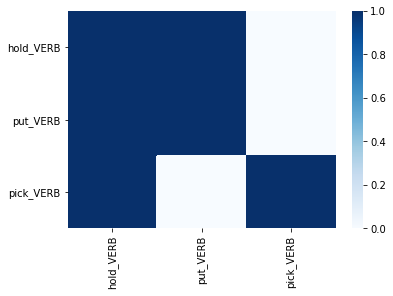

In [111]:
mn = train.X.min()
mx = train.X.max()
avg_train = avg_mat(train, top_words)
#avg_dev = avg_mat(rdev_tup, rtop_words)

sum_lines = []
get_sims(avg_train, dev.X, top_words, dev.y, None, dev.meta, repdir, save=config['LOG'])

## Figures

In [112]:
#reducer = TruncatedSVD(n_components=2)
reducer = TSNE(n_components=2, perplexity=20)

#red_tr = reducer.fit_transform(X_train_red)
#red_dv = reducer.fit_transform(X_dev_red)
print(train.X.shape)
print(dev.X.shape)
print(avg_train.shape)
#print(avg_dev.shape)
red = reducer.fit_transform(np.vstack((train.X, dev.X, avg_train)))
#red = reducer.fit_transform(np.vstack((X_train, X_dev)))
#red = np.vstack((X_train, X_dev))
print(red.shape)

(57, 2)
(63, 2)
(3, 2)
(123, 2)


['hold_VERB', 'pick_VERB', 'put_VERB']
['10_2b', '11_1c', '12_2c', '13_1a', '14_2a', '16_2b', '17_1c', '18_2c', '2_2a', '6_2c', '7_1a', '8_2a', '9_1b']


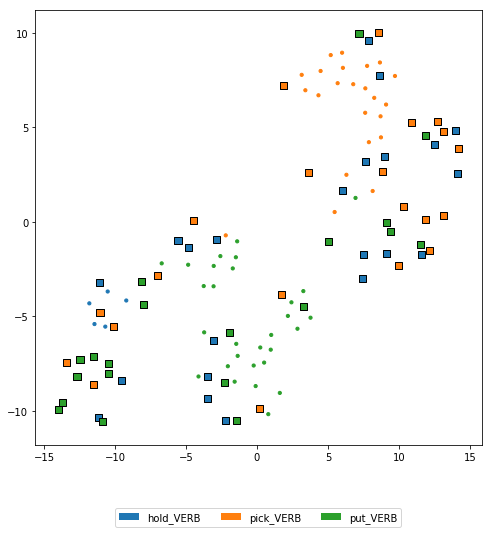

In [114]:
plt.figure(figsize=(8,8))

word_order = sorted(list(set(train.y)))
part_order = sorted(list(set([e.split()[0] for e in train.meta])))
print(word_order)
print(part_order)
train_end = train.X.shape[0]
dev_end = train_end + dev.X.shape[0]
avg_train_end = dev_end + len(top_words)
avg_dev_end = avg_train_end + len(top_words)

color_by_word = True

L = len(color_lst)

# train words
if color_by_word:
    tr_colors = [color_lst[word_order.index(y)%L] for y in train.y if y in word_order]
    dv_colors = [color_lst[word_order.index(y)%L] for y in dev.y if y in word_order]
else:
    tr_colors = [color_lst[part_order.index(p.split()[0])%L] for p in train.meta]
    dv_colors = [color_lst[part_order.index(p.split()[0])%L] for p in dev.meta]
    
plt.scatter(red[:train_end, 0], red[:train_end, 1], s=10, color=tr_colors)

# centroids of train words
#if color_by_word:
#    plt.scatter(red[dev_end:avg_train_end, 0], red[dev_end:avg_train_end, 1], s=100,
#            color=[color_lst[word_order.index(y)%L] for y in top_words], linewidth=1, edgecolor='k')

# dev words
plt.scatter(red[train_end:dev_end, 0], red[train_end:dev_end, 1], s=50, color=dv_colors,
            marker='s', linewidth=1, edgecolor='k')

# centroids of dev words
#plt.scatter(red[avg_train_end:, 0], red[avg_train_end:, 1], s=50,
#            color=[color_lst[word_order.index(y)%L] for y in top_words], marker='s', linewidth=1, edgecolor='k')

if color_by_word:
    legend_elements = [Patch(facecolor=color_lst[i%L], label=word_order[i]) for i in range(len(word_order))]
else:
    legend_elements = [Patch(facecolor=color_lst[i%L], label=part_order[i]) for i in range(len(part_order))]
plt.legend(handles=legend_elements, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.2))

#plt.savefig("%s/big_scatter.pdf"%figdir, bbox_inches='tight')
#plt.savefig("big_scatter_for_career.pdf"%figdir, bbox_inches='tight')
plt.show()

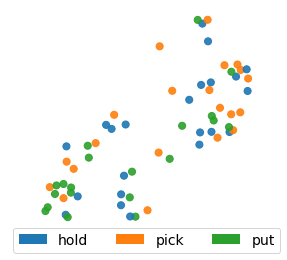

In [113]:
prop_cycle = plt.rcParams['axes.prop_cycle']
color_lst = prop_cycle.by_key()['color']

plt.figure(figsize=(4,4))

word_order = sorted(list(set(train.y)))
part_order = sorted(list(set([e.split()[0] for e in train.meta])))
train_end = train.X.shape[0]
dev_end = train_end + dev.X.shape[0]
avg_train_end = dev_end + len(top_words)
avg_dev_end = avg_train_end + len(top_words)

color_by_word = True

L = len(color_lst)

# train words
tr_colors = [color_lst[word_order.index(y)%L] for y in train.y if y in word_order]
dv_colors = [color_lst[word_order.index(y)%L] for y in dev.y if y in word_order]
    
#plt.scatter(red[:train_end, 0], red[:train_end, 1], s=30, color=tr_colors, alpha=0.9)
plt.scatter(red[train_end:dev_end, 0], red[train_end:dev_end, 1], s=50, color=dv_colors,
           linewidth=1, alpha=0.9)

legend_elements = [Patch(facecolor=color_lst[i%L], 
                             label=word_order[i].split('_')[0]) for i in range(len(word_order))]
plt.legend(handles=legend_elements, loc='lower center',
           ncol=5, bbox_to_anchor=(0.5, -0.15), fontsize=14)

plt.axis('off')
plt.savefig("big_scatter_for_career.pdf", bbox_inches='tight')
plt.show()

In [ ]:
f_logs = {}
for line in open(rootdir+'/feature_dump.tsv').readlines():
    w, p, t, steps, _, _, feats = line.strip().split('\t')
    f_logs['%s %s %s %s'%(p, t, steps.split('-')[0], steps)] = json.loads(feats)

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
clst = prop_cycle.by_key()['color']

def sign(n):
    if n < 0:
        return '-'
    return '+'

debug_lbls = ['pick_VERB', 'put_VERB', 'hold_VERB']
tr_ex = [(e, l) for e, l in zip(train.meta, train.y)]
dv_ex = [(e, l) for e, l in zip(tune_m, tune_y)]


for d in ['x', 'y', 'z']:
    for lst, nm in [(tr_ex, 'train')]: #, (dv_ex, 'dev')]:
        for example, ex_lbl in lst:
            if ex_lbl in debug_lbls:
                fs = f_logs[example]
                traj = []
                start = 0 #fs["most_moving_traj_start_%s"%d]
                c1 = fs['most_moving_traj_st-kp1_%s'%d]
                c2 = fs['most_moving_traj_kp1-kp2_%s'%d]
                c3 = fs['most_moving_traj_kp2-end_%s'%d]
                #print('%s\t%s'%(ex_lbl, ' '.join([sign(c1), sign(c2), sign(c3)])))
                traj = [start, start+c1, start+c1+c2, start+c1+c2+c3]
                if nm == 'train':
                    lw = 0.5
                    alpha = 0.5
                else:
                    lw = 2
                    alpha = 1
                plt.plot(traj, color=clst[debug_lbls.index(ex_lbl)], label=ex_lbl, linewidth=lw, alpha=alpha)
    #plt.legend()
    plt.title(d)
    plt.show()

In [ ]:
for i, fname in enumerate(feat_names):
    a = train.X[[i for i,y in enumerate(train.y) if (y == 'pick_VERB')], i]
    b = train.X[[i for i,y in enumerate(train.y) if (y == 'put_VERB')], i]
    if ttest_ind(a, b)[1] <= 0.05:
        print(fname)
        plt.hist([a,b], density=True)
        plt.show()

In [ ]:
outpath=figdir
vocab_mat_figures(outpath, 'raw_train', avg_train, top_words, mn, mx, 'png', save=config['LOG'])
#vocab_mat_figures(outpath, 'raw_dev', avg_dev, top_words, mn, mx, 'png', save=config['LOG'])
vocab_mat_figures_indv(outpath, train, mn, mx, 'png', save=config['LOG'])
vocab_mat_figures_indv(outpath, dev, mn, mx, 'png', save=config['LOG'])

## Label Unlabelled

In [ ]:
blind = eval_on_random(config, spatial_data, vocab_lsts, count_lsts)
print(blind.X.shape)

if config['RED'] == True:
    blind.X = trained_reducer.transform(blind.X)
    
outfile = open('%s/blind_eval.txt'%repdir, 'w')

sims = cosine_similarity(blind.X, avg_train)

for i in range(len(blind.meta)):
    
    max_idxs = [e for e in reversed(sims[i, :].argsort())] # to get descending order
    plst = []
    for idx in max_idxs:
        plst.append('%s=%.04f'%(top_words[idx], sims[i, idx]))
    
    #outfile.write('%s\t%s\t%s\n'%(blind_meta[i], blind_y[i], '\t'.join(plst)))
    outfile.write('model\t%s\t%s\t%s\t%s\n'%(blind.meta[i], blind.y[i],
                                             plst[0].split('=')[0], '\t'.join(plst)))
    outfile.write('rand\t%s\t%s\t%s\t%s\n'%(blind.meta[i], blind.y[i],
                                            random.choice(plst).split('=')[0], '\t'.join(plst)))
outfile.close()

## CNN Baselines

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from pretrained_cnns.alexnet import alexnet
from pretrained_cnns.vgg import vgg19
from pretrained_cnns.vgg import vgg11
from pretrained_cnns.resnet import resnet101
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image

resnet = resnet101(pretrained=True)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [57]:
# compute cnn data for every embedding
# this is slow but gets the job done for now

def get_emb(p, t, s):
    img_path = 'cnn_baselines/images/%s/%s_task%s/%s.png'%(p, p, t, s)
    if os.path.exists(img_path):
        #sys.stderr.write('%s\n'%img_path)
        input_tensor = preprocess(Image.open(img_path))
        input_batch = input_tensor.unsqueeze(0)
        with torch.no_grad():
            return resnet.forward(input_batch)
                
out = open('cnn_embeddings.txt', 'w')

top_words = get_top_words(config['POS'])
_data = [row for row in csv.DictReader(open(config['DATA']), delimiter='\t')]
_data = [d for d in _data if '%s_%s'%(d['lemma'], d['pos']) in top_words]
print("len(_data)", len(_data))

done = set()
with open('cnn_embeddings_backup.txt') as f:
    for line in f:
        p, t, s, _ = line.strip().split('\t')
        done.add('%s-%s-%s'%(p, t, s))
#for midx, m in enumerate(filtered_data.meta):
    #p, t, _, se = m.split()
    #s, e = se.split('-')
    #if midx % 100 == 0:
for idx, d in enumerate(_data):
    p = d['participant']
    t = d['task'][-1]
    i = int(d['step'])

    if i % 10 == 0:
        sys.stderr.write('%s %s\n'%(p, t))
        
    if '%s-%s-%s'%(p, t, i) not in done:
        resout = get_emb(p, t, i)
        if resout is not None:
            out.write('%s\t%s\t%s\t%s\n'%(p, t, i,
                                    ' '.join(['%s'%v.item() for v in resout])))
    s = 10 * (int(i/10))
    for j in range(s, s+config['WINDOW'], 100):
        if '%s-%s-%s'%(p, t, j) in done:
            continue
        try:
            resout = get_emb(p, t, s)
        except OSError:
            print("OSError on %s %s %s"%(p, t, i))
            continue
        if resout is not None:
            out.write('%s\t%s\t%s\t%s\n'%(p, t, j,
                                    ' '.join(['%s'%v.item() for v in resout])))
out.close()


len(_data) 968
OSError on 6_2c 6 45244
OSError on 6_2c 6 45244
OSError on 6_2c 6 45244
OSError on 6_2c 6 45244
OSError on 6_2c 6 45244


1_1a 1
1_1a 1
1_1a 1
1_1a 2
1_1a 3
1_1a 3
1_1a 3
1_1a 4
1_1a 6
2_2a 1
2_2a 2
2_2a 4
2_2a 5
2_2a 6
3_1b 3
3_1b 4
3_1b 6
4_2b 1
4_2b 3
4_2b 3
4_2b 4
4_2b 5
5_1c 2
5_1c 5
5_1c 6
6_2c 1
6_2c 2
6_2c 2
6_2c 2
6_2c 3
6_2c 3
6_2c 3
6_2c 3
6_2c 3
6_2c 3
6_2c 3
6_2c 4
6_2c 4
6_2c 6
6_2c 6
7_1a 1
7_1a 1
7_1a 1
7_1a 3
7_1a 6
8_2a 1
8_2a 1
8_2a 2
8_2a 4
8_2a 6
9_1b 1
9_1b 1
9_1b 3
9_1b 3
9_1b 6
10_2b 1
10_2b 2
10_2b 3
10_2b 4
10_2b 4
10_2b 5
10_2b 5
11_1c 1
11_1c 6
12_2c 3
12_2c 3
12_2c 3
12_2c 6
13_1a 1
13_1a 2
13_1a 6
13_1a 6
13_1a 6
14_2a 2
14_2a 2
14_2a 3
14_2a 4
14_2a 6
15_1b 1
15_1b 4
15_1b 4
15_1b 5
15_1b 5
15_1b 6
16_2b 1
16_2b 2
16_2b 3
17_1c 1
17_1c 2
17_1c 6
17_1c 6
17_1c 6
18_2c 2
18_2c 2
18_2c 3


In [ ]:
_data = [row for row in csv.DictReader(open(config['DATA']), delimiter='\t')]
_data = [d for d in _data if (d['participant'] == '10_2b') and (d['step'][-1] == '0')]
for d in _data[:5]:
    img_path = 'cnn_baselines/images/%s_task%s/%s.png'%(d['participant'],
                                                        d['task'], d['step'])
    input_tensor = preprocess(Image.open(img_path))
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        resout = resnet.forward(input_batch)
        print(resout)

In [ ]:
dataset = datasets.ImageFolder('cnn_baselines/images/', transform=preprocess)
data_loader = DataLoader(dataset, batch_size=1000)

In [ ]:
with torch.no_grad():
    for img, lbl in data_loader:
        resout = resnet.forward(img)
        print(resout)
        break